In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.calibration import calibration_curve
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [47]:
df = pd.read_csv('Train_Split.csv')
df = df.drop(columns='variance')
df.describe()

,skewness,curtosis,entropy,y
count,1097.000000,1097.000000,1097.000000,1097.000000
mean,1.841192,1.438955,-1.137623,0.444850
std,5.856025,4.341728,2.045680,0.497176
min,-13.677900,-5.286100,-8.548200,0.000000
25%,-1.783700,-1.532300,-2.213400,0.000000
50%,2.236900,0.650050,-0.572420,0.000000
75%,6.816200,3.366200,0.394810,1.000000
max,12.951600,17.677200,2.449500,1.000000


In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['y']), df['y'],test_size=0.3,random_state=42,stratify=df['y'])

In [49]:
cv = StratifiedKFold()
model = TPOTClassifier(generations=5, population_size=200, cv=cv, scoring='f1', verbosity=2, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


Optimization Progress:   0%|          | 0/1200 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9662903353096942

Generation 2 - Current best internal CV score: 0.9662903353096942

Generation 3 - Current best internal CV score: 0.9662903353096942

Generation 4 - Current best internal CV score: 0.9662903353096942

Generation 5 - Current best internal CV score: 0.9692508818081208

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=6, p=1, weights=distance)


TPOTClassifier(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
               generations=5, n_jobs=-1, population_size=200, random_state=42,
               scoring='f1', verbosity=2)

In [34]:
preds = model.predict(X_test)

print(accuracy_score(y_test,preds))
print(f1_score(y_test,preds))

0.9636363636363636
0.9591836734693877


In [35]:
model.export('model_new.py')

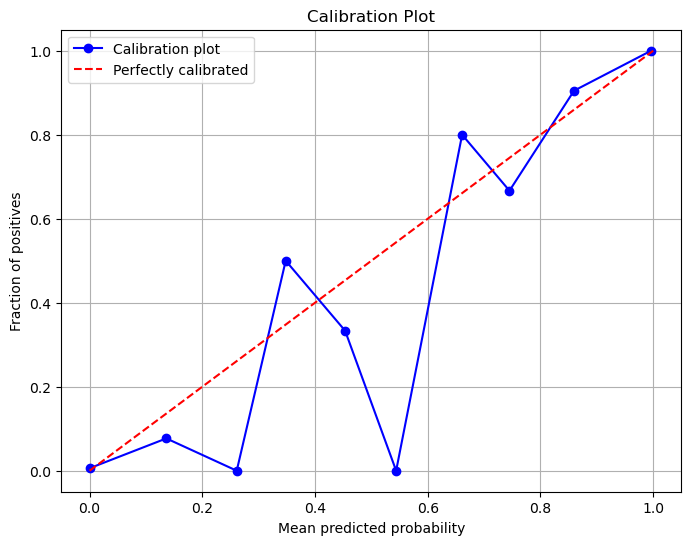

In [40]:
results = model.predict_proba(X_test) [:,1]
prob_true, prob_pred = calibration_curve(y_test, results, n_bins=10,strategy='uniform')
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid()
plt.show()

In [43]:
from sklearn.calibration import CalibratedClassifierCV

exported_model = KNeighborsClassifier(n_neighbors=6, p=1, weights="distance")
# Fix random state in exported estimator
if hasattr(exported_model, 'random_state'):
    setattr(exported_model, 'random_state', 42)

exported_model.fit(X_train,y_train)
    
calibrated_classifier = CalibratedClassifierCV(exported_model,method='sigmoid', cv='prefit')
calibrated_classifier.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=KNeighborsClassifier(n_neighbors=6, p=1,
                                                      weights='distance'))

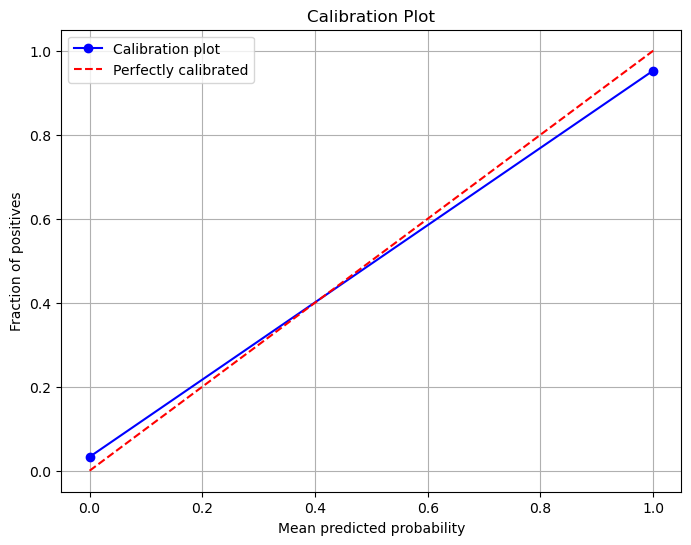

In [42]:
results = calibrated_classifier.predict(X_test)
prob_true, prob_pred = calibration_curve(y_test, results, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='blue', label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid()
plt.show()

In [45]:
from joblib import dump, load
dump(exported_model, 'uncalibrated_model.joblib')
dump(calibrated_classifier,'calibrated_classifier.joblib') 

['calibrated_classifier.joblib']